## Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from math import ceil

In [3]:
df = pd.read_csv('/content/output.csv', index_col='Unnamed: 0')

## Boxplots, Histograms, Descriptive Statistics

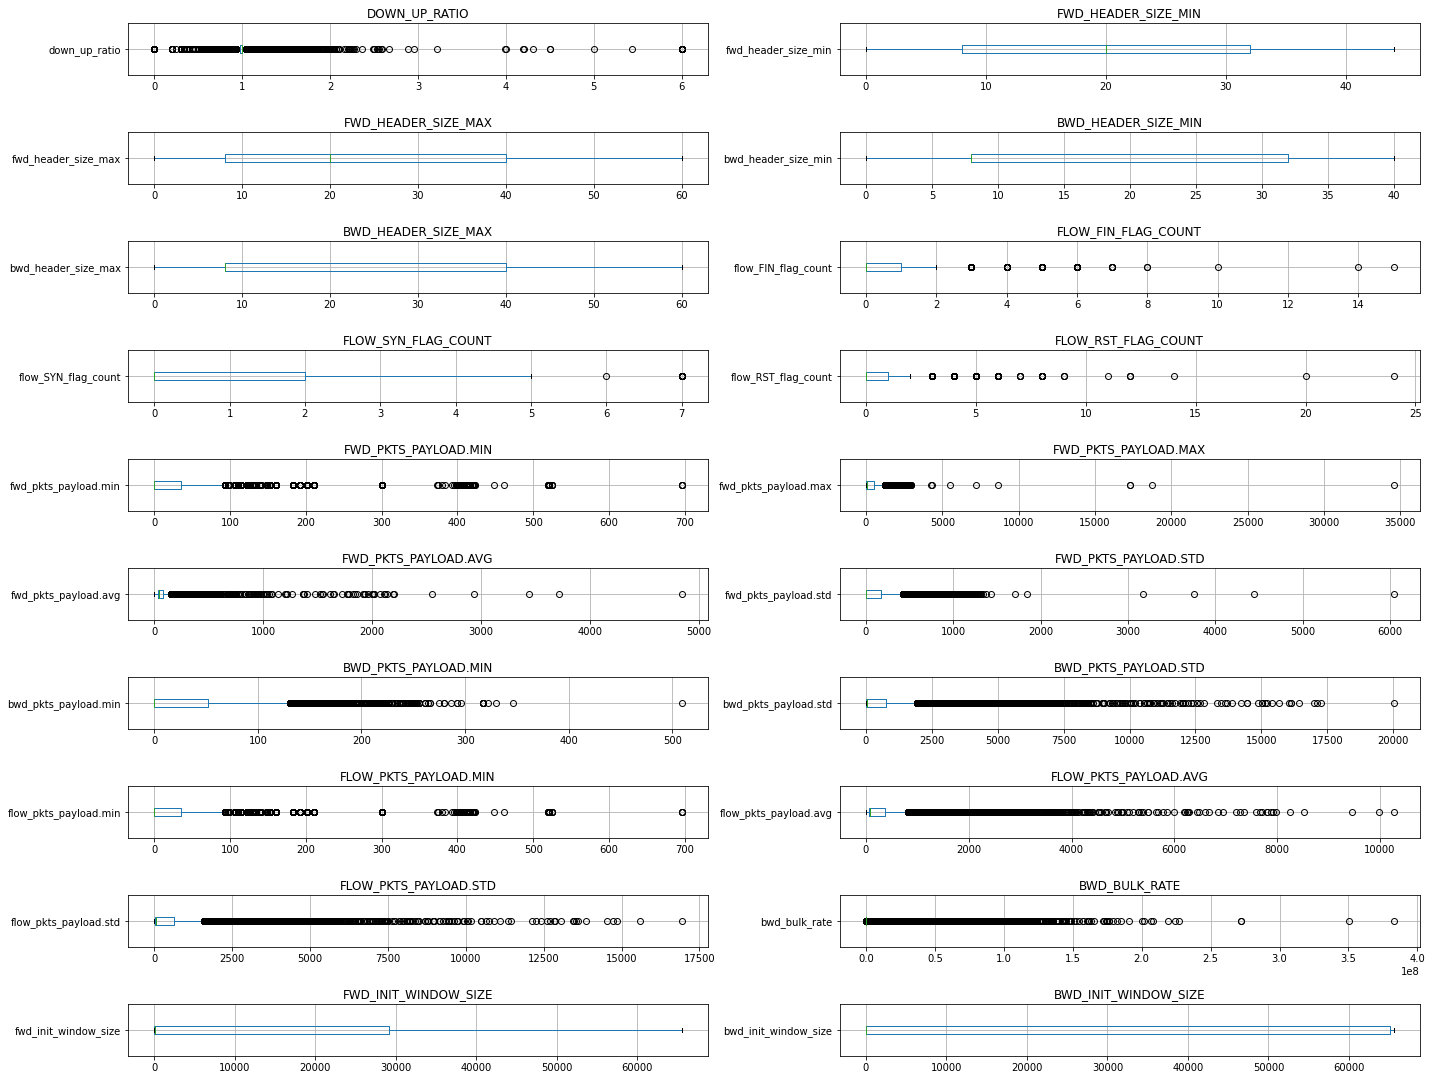

In [ ]:
plt.figure(figsize=(20, 30))

for i, col in enumerate(df.drop(columns=['label'])):
    # add a new subplot iteratively
    ax = plt.subplot(ceil(len(df.columns) - 1), 2, i+1)

    df.boxplot(col, vert=False, ax=ax)
  
    # chart formatting
    ax.set_title(col.upper())
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

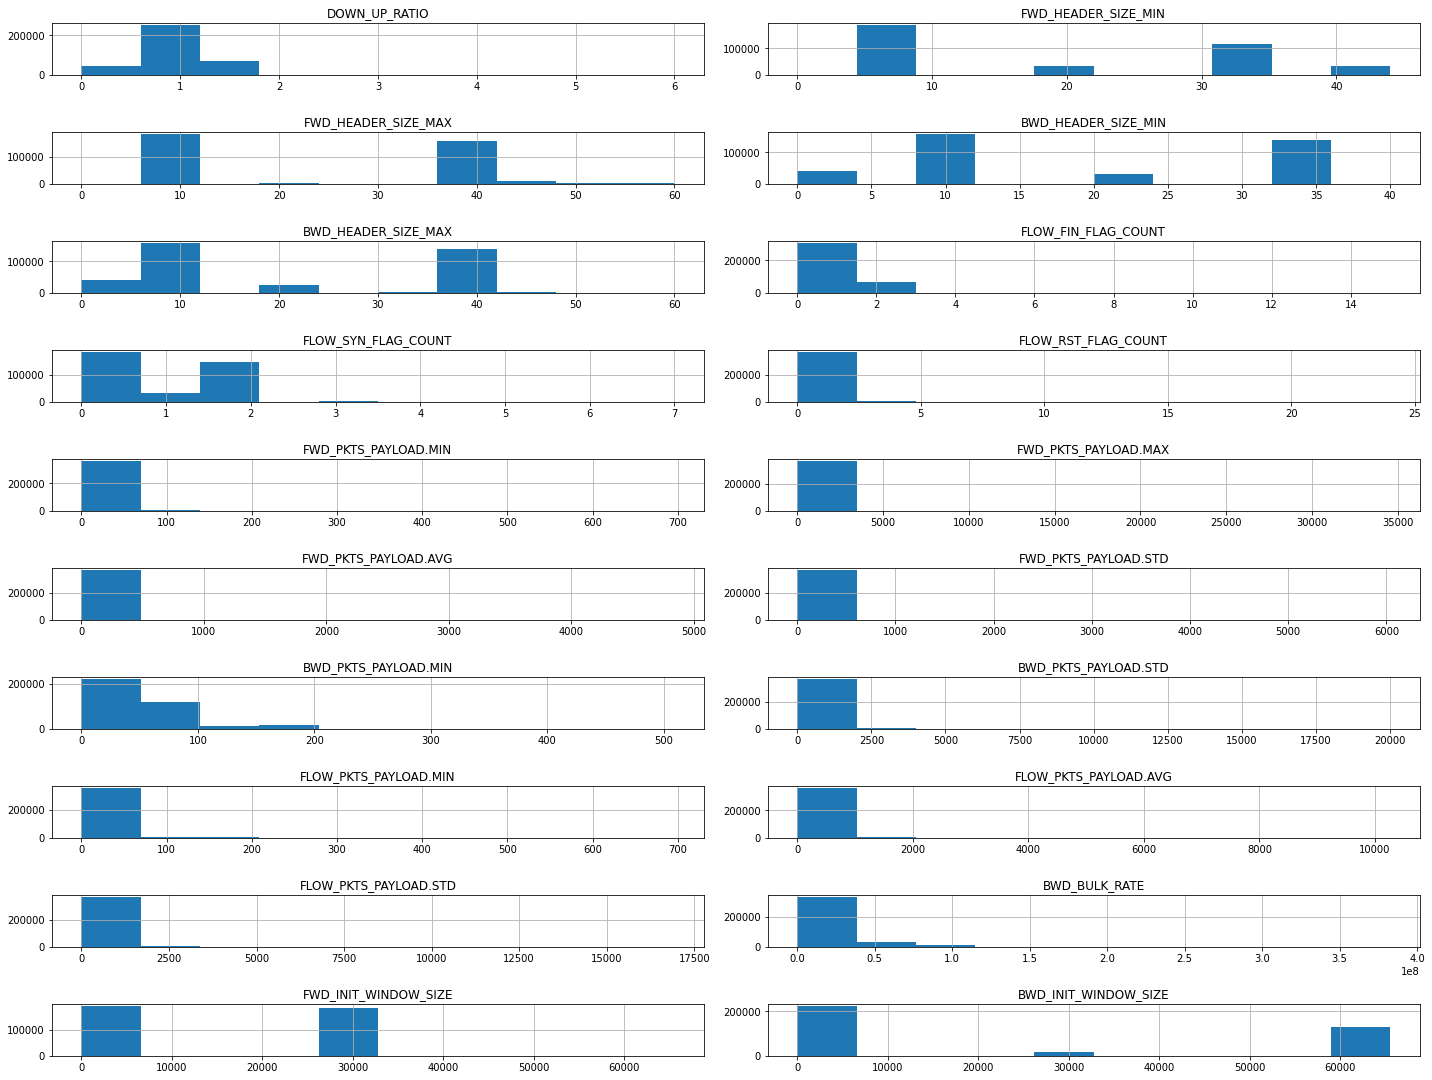

In [ ]:
plt.figure(figsize=(20, 30))

for i, col in enumerate(df.drop(columns=['label'])):
    # add a new subplot iteratively
    ax = plt.subplot(ceil(len(df.columns) - 1), 2, i+1)

    df[col].hist()
  
    # chart formatting
    ax.set_title(col.upper())
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

Based on these boxplots and histograms we can make these insights:
1. A lot of the data is sparse; this will affect the EDA workflow (e.g. log transformations on histogram plots)
2. There isn't any data that is normally distributed, thus, during the modeling process, I will need to use a MinMaxScaler, rather than a StandardScaler.

In [ ]:
df['label'].value_counts(normalize=True)

0    0.936929
1    0.063071
Name: label, dtype: float64

There is a large class imbalance for the dependent target variable (~94%/6%) and that will need to be addressed with oversampling. Undersampling would result in a model being unable to classify properly--low accuracy, precision, and recall. Oversampling will address the class imbalance, prevent the model from classifying unevenly, and will give the model enough data to classify properly.

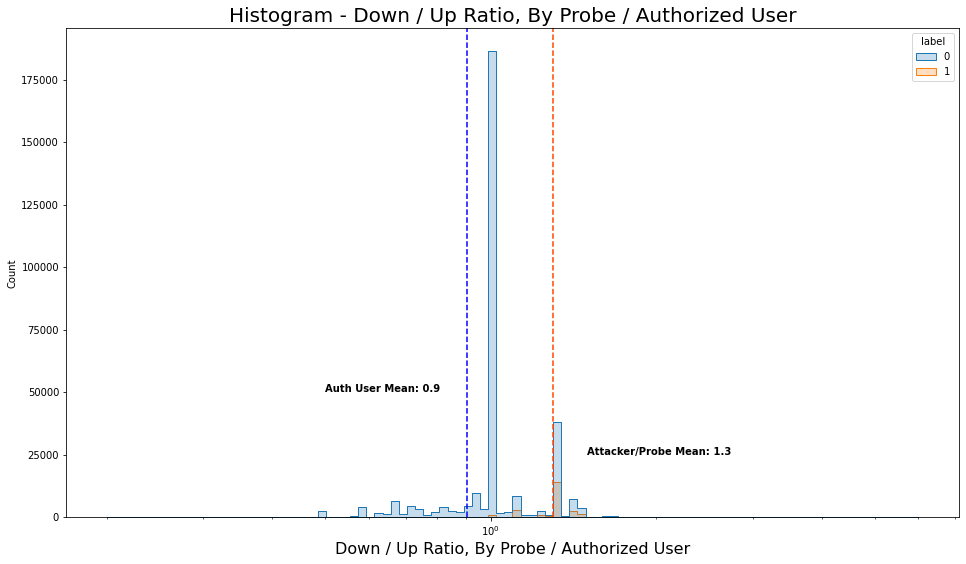

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Histogram - Down / Up Ratio, By Probe / Authorized User', fontsize=20)
plt.xlabel('Down / Up Ratio, By Probe / Authorized User', fontsize=16)

auth_user_du_mean = df.groupby('label')['down_up_ratio'].mean()[0]
attacker_du_mean = df.groupby('label')['down_up_ratio'].mean()[1]

# Auth User Mean Line
plt.axvline(
    auth_user_du_mean, 
    c='blue', 
    ls='--')
plt.text(
    0.5, 
    50_000,
    f'Auth User Mean: {round(auth_user_du_mean, 2)}',
    weight='bold')

# Attacker Mean Line
plt.axvline(
    attacker_du_mean, 
    c='orangered', 
    ls='--')
plt.text(
    1.5, 
    25_000,
    f'Attacker/Probe Mean: {round(attacker_du_mean, 2)}',
    weight='bold')

sns.histplot(df[df['down_up_ratio'] > 0], x='down_up_ratio', hue='label', element='step', log_scale=True, bins=100);

This measurement is the download to upload ratio of data from the user/attacker side. The authorized user packet distribution (blue) is bimodal, and the attacker distribution tends to follow one of the subpopulations. The likely reason this is the case is because attackers that are undergoing probing or scanning tend to only download information- and they are trying to limit that amount of packets uploaded as to not leave too much information behind. Authorized users will spend more time on a server taking some kind of action, and they will generally have a more evenly distributed down/up ratio. Thus, the down/up ratios of cyberattackers will have a higher mean (more download, less upload) than the down/up ratios of authorized users.

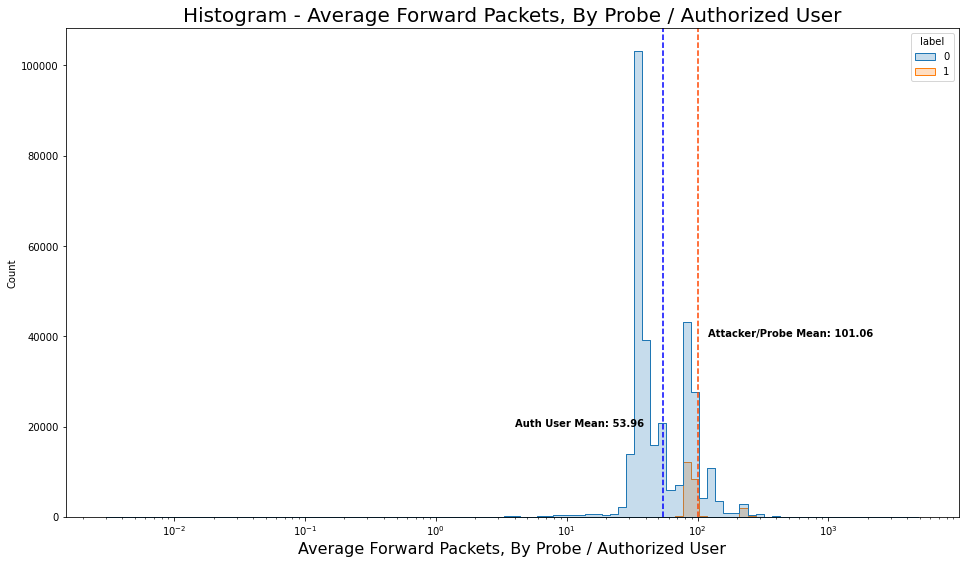

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Histogram - Average Forward Packets, By Probe / Authorized User', fontsize=20)
plt.xlabel('Average Forward Packets, By Probe / Authorized User', fontsize=16)

auth_user_fp_mean = df.groupby('label')['fwd_pkts_payload.avg'].mean()[0]
attacker_fp_mean = df.groupby('label')['fwd_pkts_payload.avg'].mean()[1]

# Auth User Mean Line
plt.axvline(
    auth_user_fp_mean, 
    c='blue', 
    ls='--')
plt.text(
    4, 
    20_000,
    f'Auth User Mean: {round(auth_user_fp_mean, 2)}',
    weight='bold')

# Attacker Mean Line
plt.axvline(
    attacker_fp_mean, 
    c='orangered', 
    ls='--')
plt.text(
    120, 
    40_000,
    f'Attacker/Probe Mean: {round(attacker_fp_mean, 2)}',
    weight='bold')

sns.histplot(df[df['fwd_pkts_payload.avg'] > 0], x='fwd_pkts_payload.avg', hue='label', element='step', log_scale=True, bins=100);

Here, we are seeing a similar packet behavior to the last histogram, where authorized users have a bimodal distribution and the mean for attackers falls higher than the majority of authorized users. Forward packets, in this case, refers to the amount of packets being sent out from the server to the user, effectively, a measurement of packets downloaded. This likely points to a similar reasoning to the last chart where attackers are going to try to get as much information as possible before cutting off that connection with a server- and that may be reflected here. On average, we are seeing more data being downloaded by attackers than by authorized users.

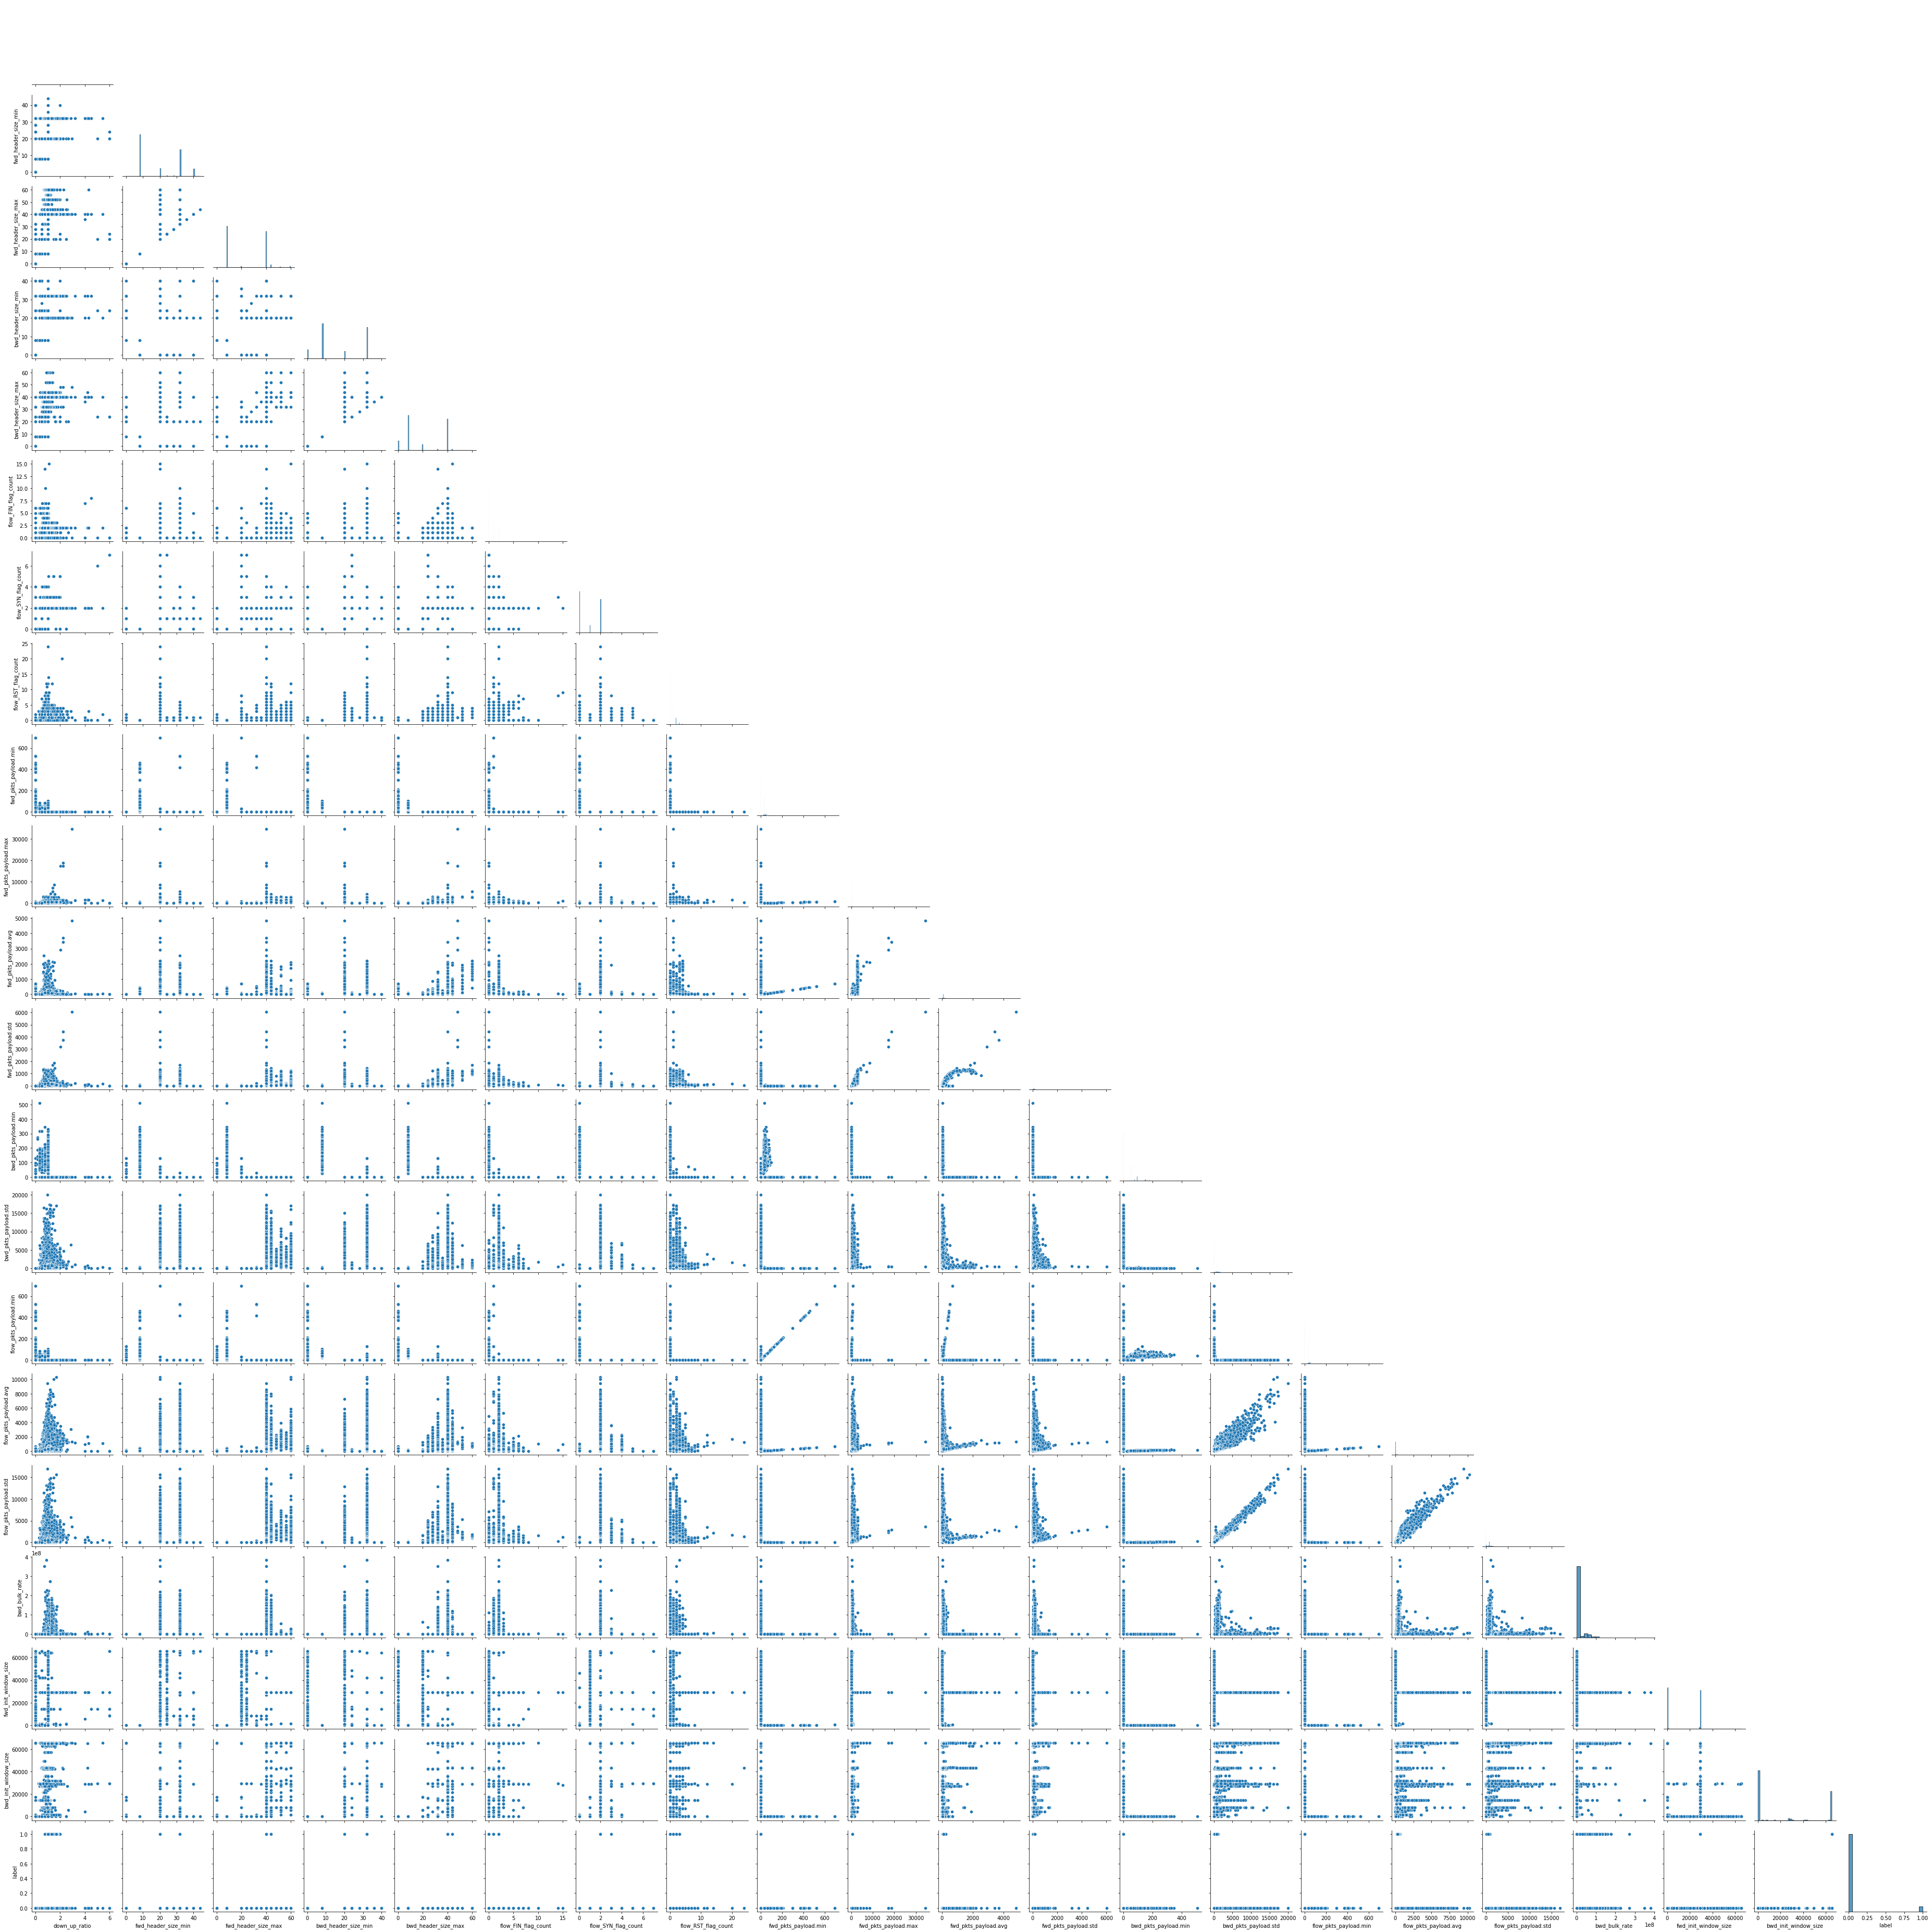

In [ ]:
# Creating a pairplot of the whole DataFrame to find any interesting patterns that would be worth examining further
sns.pairplot(df, corner=True);

Looking at general trends, we are seeing indicators of the sparseness of the dataset with a lot of scatter points near the left sides of these plots, but we are also seeing indicators of multi-collinearity as well with some features being very correlated. This will affect the decision making during the modeling phase as some transformations will be needed to be made to address multi-collinearity. This makes sense as a lot of these measurements are mathematical summary features (such as min, max, avg, std), but also conceptually and technically, all of these features are correlated to one another as packets are getting sent out. Larger header sizes for example, are going to be indicative of larger packet sizes, and that will likely be reflected in some of the other features in the dataset.

## Exploratory Scatter Plots

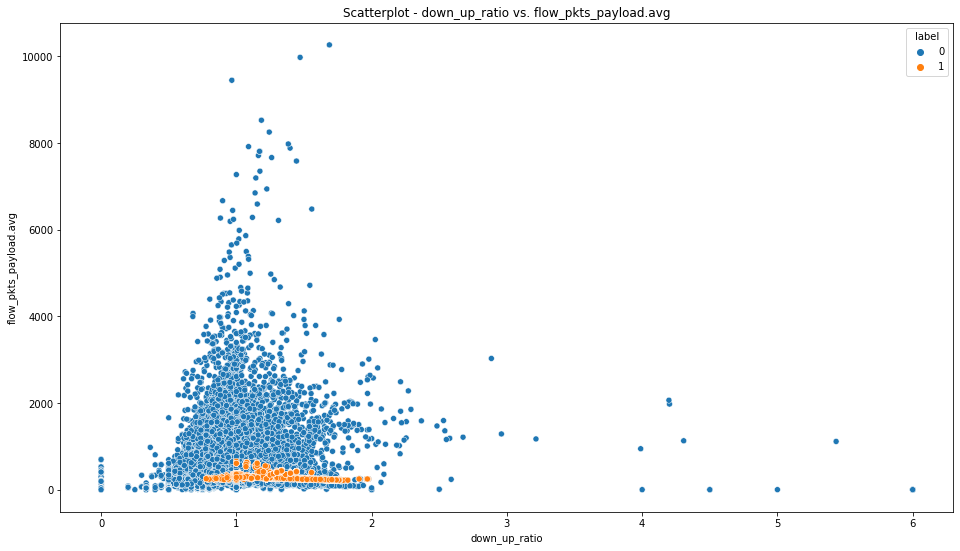

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Scatterplot - down_up_ratio vs. flow_pkts_payload.avg')
sns.scatterplot(data=df, x='down_up_ratio', y='flow_pkts_payload.avg', hue='label');

With this scatterplot we can have a better understanding and deep dive into some of the features that we've looked at before. This is download/upload ratio compared with the average flow of packets in any given payload or row in the datset. We see that the down up ratio for attackers tends to aggregate between 1 and 2 while maintaining a flow average packet flow. We also see down/up ratio outliers, but all of them are authorized users. These are users downloading an unusual amount of data for some reason or official use case.

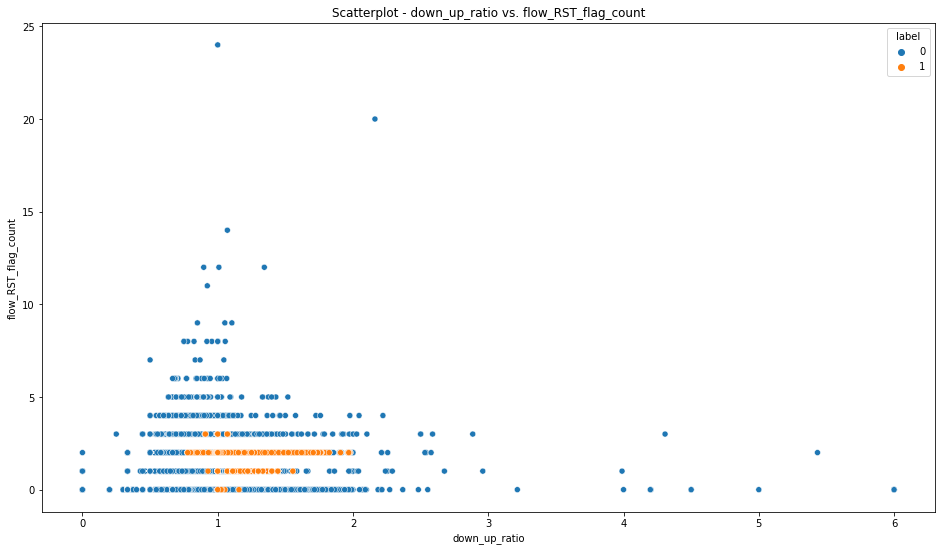

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Scatterplot - down_up_ratio vs. flow_RST_flag_count')
sns.scatterplot(data=df, x='down_up_ratio', y='flow_RST_flag_count', hue='label');

With this scatterplot, we see a similar shape forming to the last one, where attackers' down/up ratio aggregates between 1 and 2, while having amount of the y variable, in this case, being flow_RST_flag_count. RST flags are indicators to the server that the connection should be severed, either because of a) a fatal error or b) the user closed out their connection. The two ways to close out a connection with a server is FIN and RST flags. However, FIN sends back and forth much more data than RST does and can be thought of as a more agreeable closed connection, whereas RST is typically more of an interrupted connection.

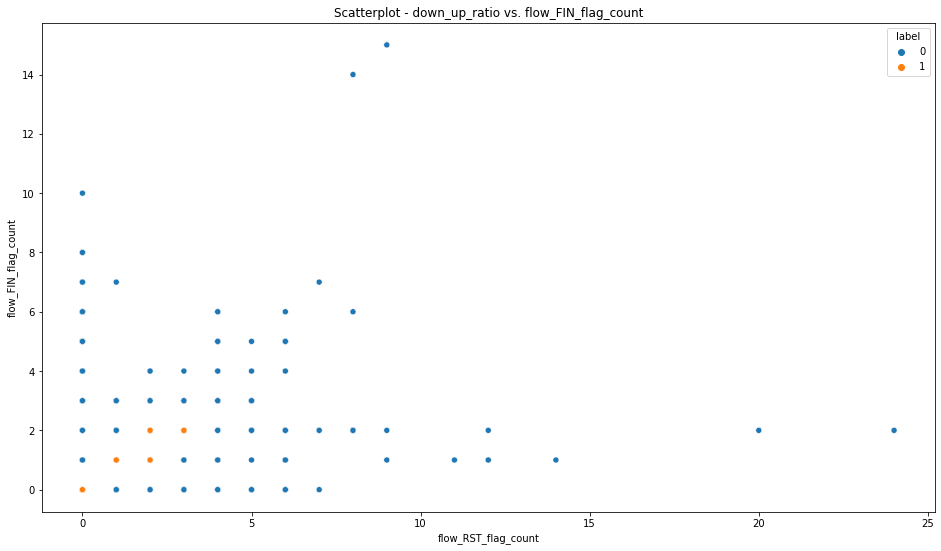

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Scatterplot - down_up_ratio vs. flow_FIN_flag_count')
sns.scatterplot(data=df, x='flow_RST_flag_count', y='flow_FIN_flag_count', hue='label');

Here we see a scatterplot which points support the ideas from the markdown above. With the orange data points being attackers, we're seeing a maximum of 2 FIN flag counts in any given scan or probe, whereas we are seeing slightly more (closer to 3) RST flag counts in any given scan or probe. An RST flag can send a single data payload (from one side to the other) to end the connection, while a FIN flag needs to have acknowledgement from both sides of the connection in order to end the connection. Generally, an attacker who is probing will want to send a few flags as possible to the server as each flag contains data with identifying information about the attacker, but in these cases, an RST flag will be preferred over a FIN flag due to the amount of packet noise that a FIN flag has versus an RST flag. 

## Making Scatterplots based on Interaction Term Coefficients

In [6]:
# Initialize features and dependent variable
X = df.drop(columns=['label'])
y = df['label']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Pipeline
pipe = Pipeline([
    ('poly', PolynomialFeatures(interaction_only=True)),
    ('minmax', MinMaxScaler()),
    ('lr', LogisticRegression(max_iter=10_000, random_state=42))
])

# Fit
pipe.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(interaction_only=True)),
                ('minmax', MinMaxScaler()),
                ('lr', LogisticRegression(max_iter=10000, random_state=42))])

In [13]:
# Dataframe to show the highest absolute coefficients
pd.DataFrame(data=pipe[2].coef_, columns=pipe[0].get_feature_names_out()).T.sort_values(by=[0], ascending=False)

,0
fwd_header_size_min flow_RST_flag_count,6.660704
flow_FIN_flag_count fwd_pkts_payload.avg,6.413850
bwd_header_size_min fwd_pkts_payload.avg,6.368658
down_up_ratio bwd_header_size_min,3.844333
down_up_ratio flow_RST_flag_count,3.736685
...,...
flow_RST_flag_count flow_pkts_payload.std,-3.709669
flow_FIN_flag_count flow_pkts_payload.std,-3.850241
flow_RST_flag_count fwd_pkts_payload.std,-4.077652
fwd_header_size_min flow_FIN_flag_count,-7.248279


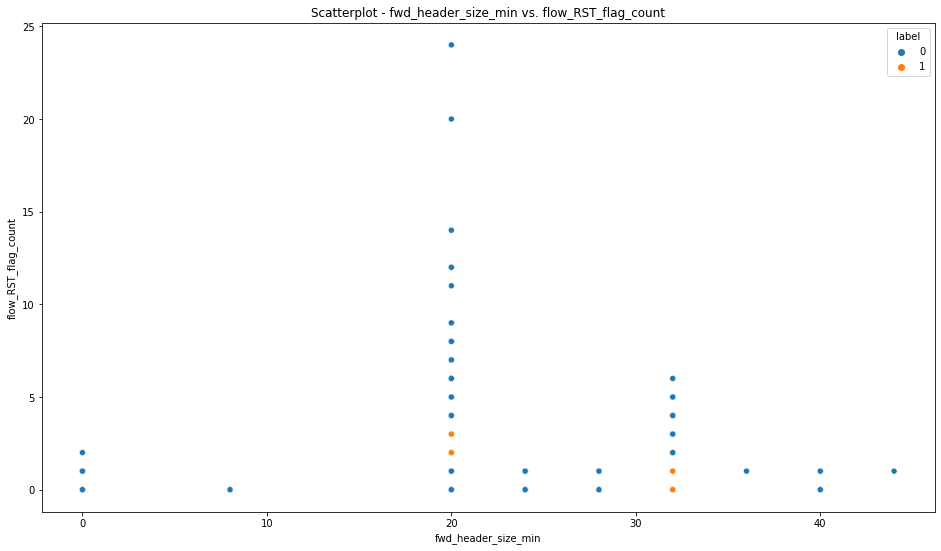

In [15]:
plt.figure(figsize=(16, 9))
plt.title('Scatterplot - fwd_header_size_min vs. flow_RST_flag_count')
sns.scatterplot(data=df, x='fwd_header_size_min', y='flow_RST_flag_count', hue='label');

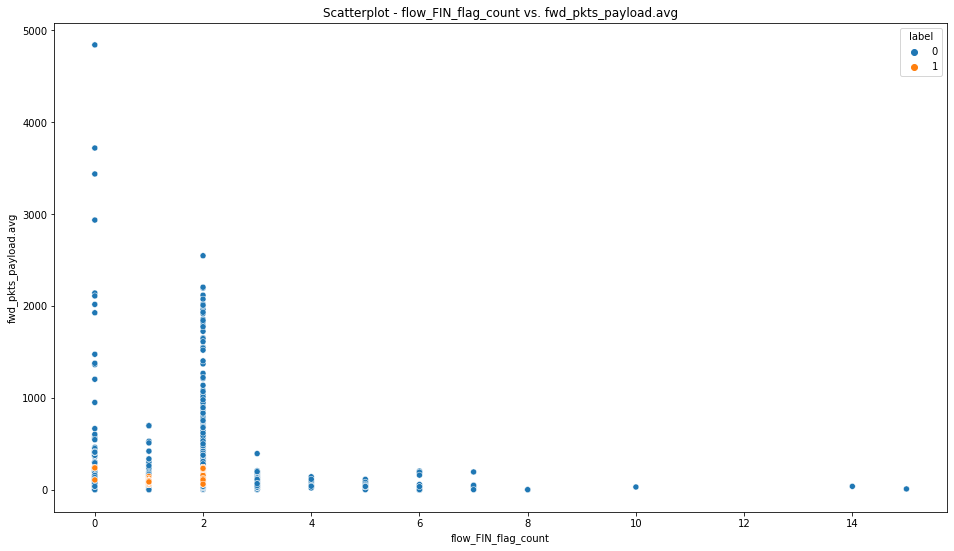

In [16]:
plt.figure(figsize=(16, 9))
plt.title('Scatterplot - flow_FIN_flag_count vs. fwd_pkts_payload.avg')
sns.scatterplot(data=df, x='flow_FIN_flag_count', y='fwd_pkts_payload.avg', hue='label');

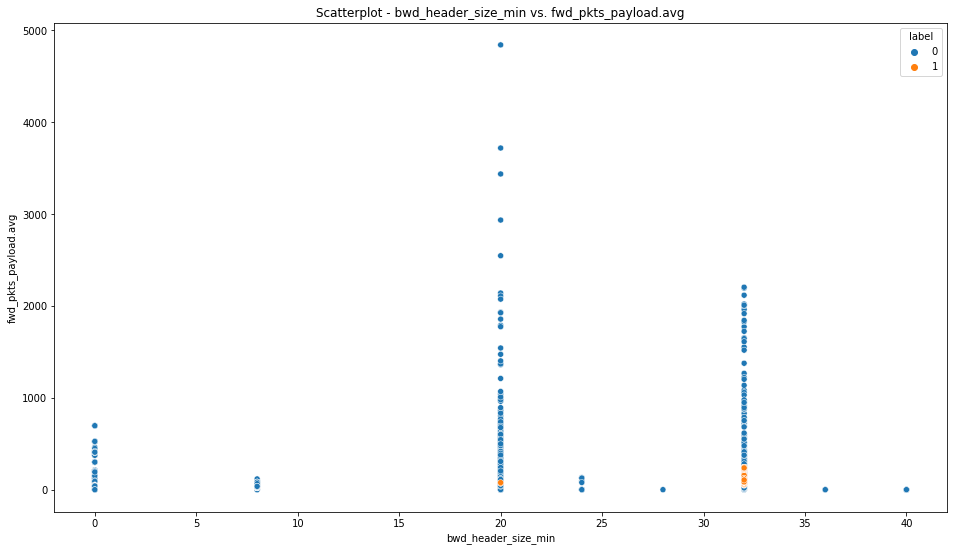

In [17]:
plt.figure(figsize=(16, 9))
plt.title('Scatterplot - bwd_header_size_min vs. fwd_pkts_payload.avg')
sns.scatterplot(data=df, x='bwd_header_size_min', y='fwd_pkts_payload.avg', hue='label');

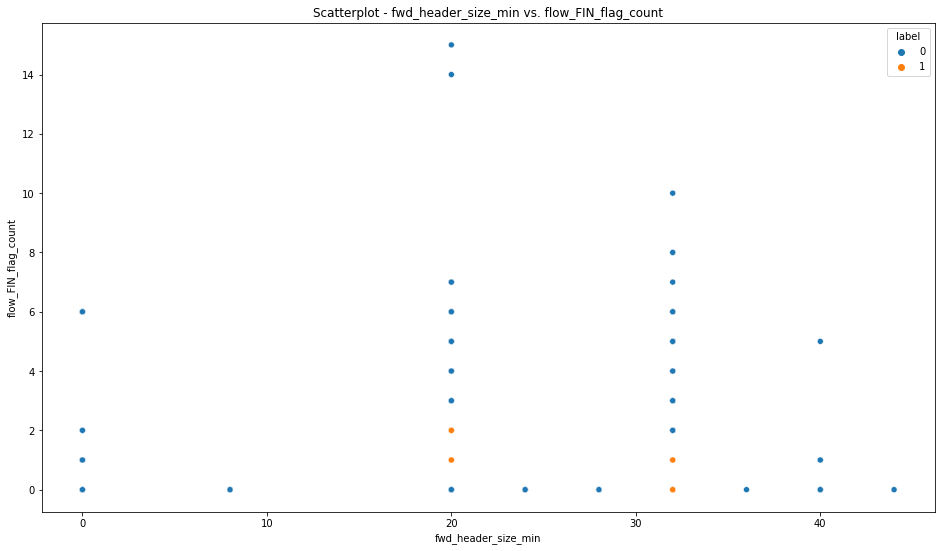

In [18]:
plt.figure(figsize=(16, 9))
plt.title('Scatterplot - fwd_header_size_min vs. flow_FIN_flag_count')
sns.scatterplot(data=df, x='fwd_header_size_min', y='flow_FIN_flag_count', hue='label');

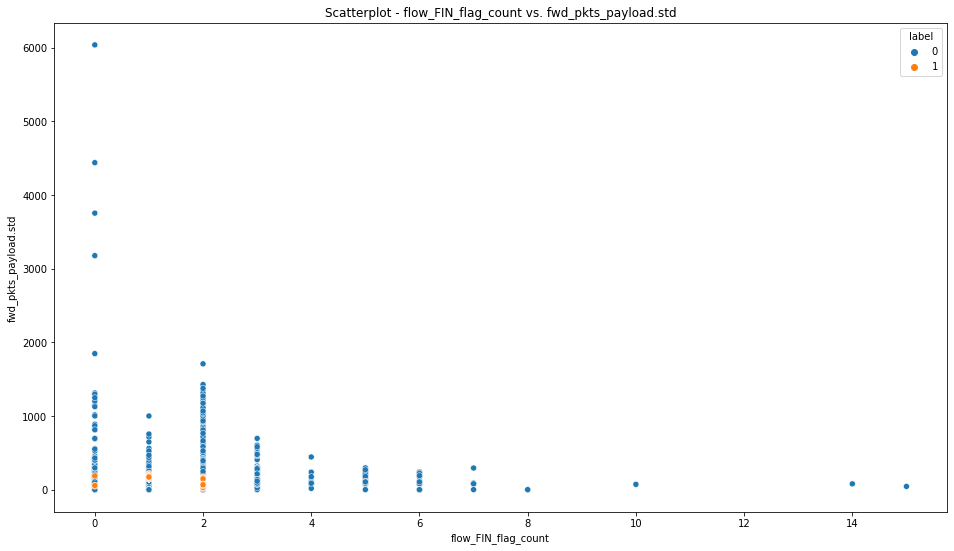

In [19]:
plt.figure(figsize=(16, 9))
plt.title('Scatterplot - flow_FIN_flag_count vs. fwd_pkts_payload.std')
sns.scatterplot(data=df, x='flow_FIN_flag_count', y='fwd_pkts_payload.std', hue='label');